In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

%load_ext autoreload

%autoreload 2

In [2]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#%cd "/content/gdrive/My Drive/sumie"

In [3]:
import sumie.inputs
import sumie.sumie
import sumie.transforms
import sumie.objectives
import sumie.montage

In [97]:
import sumie.utils
model = torchvision.models.vgg16(pretrained=True).eval()
model.features[-1] = torch.nn.AdaptiveMaxPool2d((7, 7))
sumie.utils.remove_inplace(model)
#sumie.utils.max_to_avg_pool(model)
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU()
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU()
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU()
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), pad

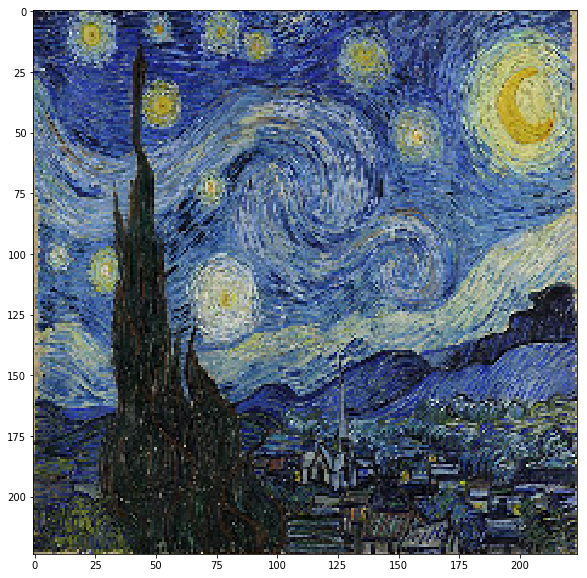

In [100]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/606px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
contents = BytesIO(response.content)
import sumie.montage
im_target_style = sumie.montage.load_image(contents, (224, 224))
im_target_style = im_target_style/255
fig = plt.figure(figsize=(10,10))
sumie.montage.show(255*im_target_style)

In [ ]:
[model.features[0], model.features[21]]

tensor(0.2356, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<AddBackward0>)


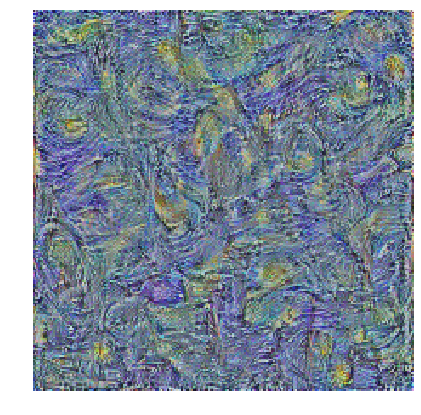

In [102]:
im = sumie.sumie.Image(224, param='rgb', decorrelate=False, 
                       transforms=[
               #sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise(),]
            )

device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.1)
steps = 500
history = np.zeros((steps, 1))
style = sumie.objectives.Style([model.features[0], model.features[5], model.features[10], model.features[17], model.features[24]], 
                                 model, 
                                 sumie.transforms.Normalise()(im_target_style).to(device))
for i in range(steps):
    optimiser.zero_grad()
    out = model.features(im())
    
    loss = style.objective
    history[i] = loss.cpu().detach().numpy()
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    #animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()
    

fig = plt.figure(figsize=(7,7))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

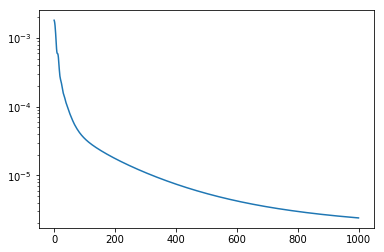

In [13]:

plt.plot(history)
plt.yscale('log')

In [ ]:
fig = plt.figure(figsize=(5,5))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

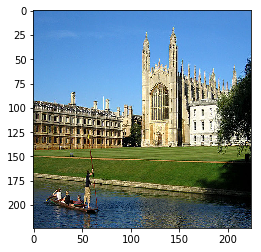

In [18]:
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/b/b4/KingsCollegeChapelWest.jpg/640px-KingsCollegeChapelWest.jpg"
from PIL import Image
import requests
from io import BytesIO

response = requests.get(url)
contents = BytesIO(response.content)
import sumie.montage
im_target = sumie.montage.load_image(contents, (224, 224))
im_target = im_target/255
sumie.montage.show(255*im_target)

In [ ]:
im = sumie.sumie.Image(224, param='rgb', decorrelate=False, limit=None,
                       transforms=[
               #sumie.transforms.PositionJitter(8),
              sumie.transforms.Normalise(),
                       ]
            )
device = 'cuda'
im.to(device)
model.to(device)
optimiser = torch.optim.Adam(im.parameters(), lr=0.1)
steps = 300
history = np.zeros((steps, 1))
content = sumie.objectives.Content(model.features[5], 
                                 model.features, 
                                 sumie.transforms.Normalise()(im_target).to(device))
                                  # im_target.to(device))
                                 
#style = sumie.objectives.Style([model.features[0], model.features[5], model.features[10], model.features[17], model.features[24]], 
#                                 model, 
#                                 sumie.transforms.Normalise()(im_target_style).to(device))
for i in range(steps):
    optimiser.zero_grad()
    out = model.features(im())
    
    loss = content.objective
    history[i] = loss.cpu().detach().numpy()
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    #animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()
    

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.get_image().cpu())

tensor(74.6705, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(4.5135, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.8384, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.3895, device='cuda:0', grad_fn=<MseLossBackward>)


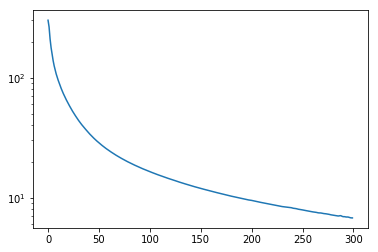

In [105]:
plt.plot(history)
plt.yscale('log')

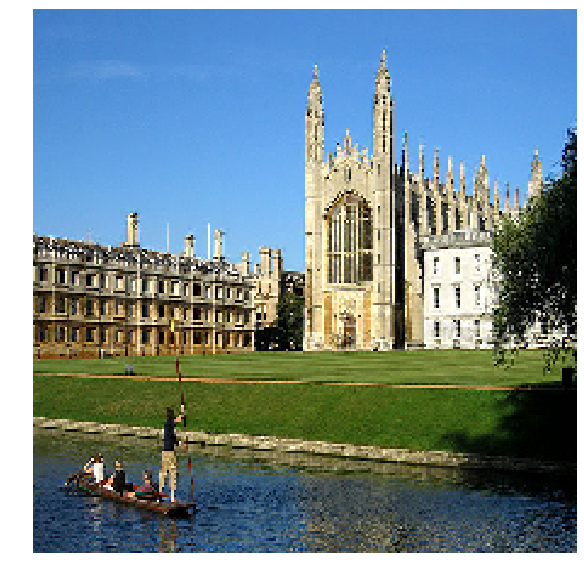

In [75]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im_target)

Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
tensor(68.1386, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(1.2372, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.7005, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.5185, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.4229, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3984, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3425, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.3117, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2857, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.2653, device='cuda:0', grad_fn=<MseLossBackward>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


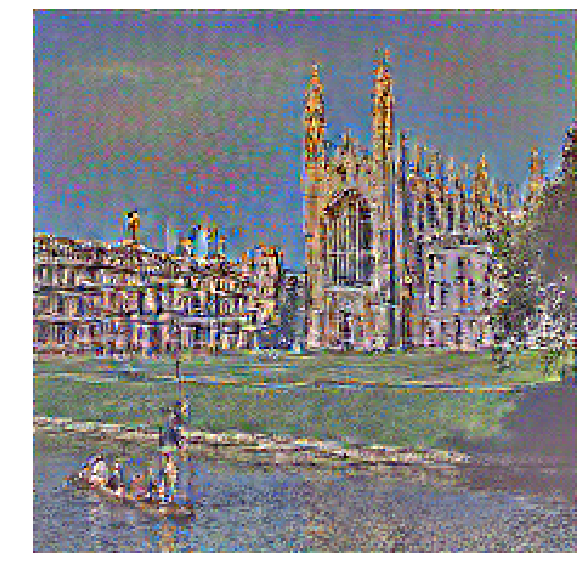

In [137]:
im = torch.zeros(1, 3, 224, 224)
im.requires_grad = True
device = 'cuda'

model.to(device)
optimiser = torch.optim.Adam([im,], lr=0.01, weight_decay=1e-5)
steps = 2000
history = np.zeros((steps, 1))


class Target():
    
    def __init__(self):
        pass
    
    def hook(self, module, hook_in, hook_out):
        self.target = hook_out.detach()
        

class Objective():
    
    def __init__(self):
        pass
    
    def hook(self, module, hook_in, hook_out):
        self.target = hook_out

t = Target()
o = Objective()
n = 17
print(model.features[n])
hook_ref = model.features[n].register_forward_hook(t.hook)
model(im_target.to(device))
hook_ref.remove()

hook_ref = model.features[n].register_forward_hook(o.hook)
criterion = torch.nn.MSELoss()

for i in range(steps):
    optimiser.zero_grad()
    out = model.features(im.to(device))
    
    loss = criterion(o.target, t.target)
    history[i] = loss.cpu().detach().numpy()
    if i % (steps/10) == 0:
        print(loss)
    loss.backward()
    
    #animation[i,:,:,:] = im.get_image().detach()
    optimiser.step()
    

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.cpu()+125)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


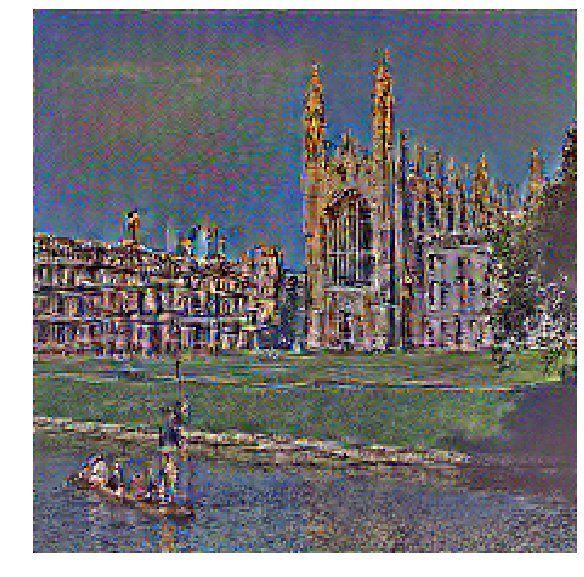

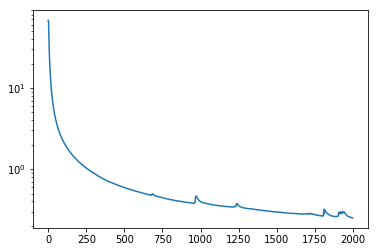

In [138]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes()
plt.axis('off')
ax.grid(False)
sumie.montage.show(255*im.cpu() + 100)
plt.plot(history)
plt.yscale('log')